# Business Problem statement


Rossmann is a European drug distributor which operates over 3,000 drug stores across seven European countries. Since a lot of drugs come with a short shelf life, that is, they do not have a long expiry date, it becomes imperative for Rossmann to accurately forecast sales at their individual stores. Currently, the forecasting is taken care of by the store managers who are tasked with forecasting daily sales for the next six weeks. 

 

As expected, store sales are influenced by many factors, including promotional campaigns, competition, state holidays, seasonality, and locality.

 

With thousands of individual managers predicting sales based on their unique circumstances and intuitions, the accuracy of the forecasts is quite varied. 

# Goal

Build a forecasting model to forecast the daily sales for the next six weeks

# Deliverables

 - Data preparation 
 - Exploratory data analysis(EDA)
 - Model Building
 - Model Evaluation 
 - Code readability and conciseness 
 

While attempting to forecast sales, it is advisable to keep the following question in mind.

 

 - Is the sales data non-stationary? If so, how do you find it and correct it?

 - Is the data cointegrated? Which variables are cointegrated and how do you find them?

 - What is the impact of the number of customers on sales?

 - What is the impact of promo and promo2 variables on sales? How do you measure it?

 - Forecast sales for the next 6 weeks? Report the accuracy of the model using MAPE.
 
 
While you are solving the problem, the following steps can be used as a reference. Please note that you can take a different approach as well.

 

-   Find outliers at the 99th percentile and remove them.

-    Standardize the sales and number of customers variables before modelling.

-    Determine if the data is stationary

-    If stationary then apply Vector Autoregression Model.

-    If non-stationary then specify the model in differences

-    Make sales, promo2 and any other variables you think of as dependent variables.

-    Check for cointegration using the Johansen test. 

-    Predict sales for the next 6 weeks.

# Import the Libraries

In [1]:
#import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import datetime
import inflection
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
from sklearn.impute import KNNImputer
import statsmodels.api as sm
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.vector_ar.vecm import coint_johansen 
import warnings
warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(15.7,6.27)})

# Load the dataset

In [2]:
df_sales_raw=pd.read_csv('train.csv')
df_store_raw=pd.read_csv('store.csv')
#Load the dataset

In [3]:
# Let's merge the dataset
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store' )
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# Data preparation & understanding

In [4]:
#Copy dataset
df_new = df_raw.copy()
df_new.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [5]:
#Let raname the columns
old_columns = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

new_columns = list( map( snakecase, old_columns ) )


#Rename Columns
df_new.columns = new_columns

In [6]:
df_new.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')


   
 -  Store - a unique Id for each store
 -  day_of_week
 -  date
 -  Sales - the turnover for any given day (this is what you are predicting)
 -  Customers - the number of customers on a given day
 -  Open - an indicator for whether the store was open: 0 = closed, 1 = open
 -  Promo - indicates whether a store is running a promo on that day
 -  State_Holiday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
 -  School_Holiday - indicates if the (Store, Date) was affected by the closure of public schools
 -  Store_Type - differentiates between 4 different store models: a, b, c, d
 -  Assortment - describes an assortment level: a = basic, b = extra, c = extended
 -  Competition_Distance - distance in meters to the nearest competitor store
 -  Competition_Open_Since[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
 -  Promo2_since_week - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
 -  Promo_2_Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
 -  Promo_Interval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store



In [7]:
#Let's check the shape of dataset
df_new.shape

(1017209, 18)

Since the company is just embarking on this project, the scope has been kept to nine key stores across Europe. The stores are key for the company keeping in mind the revenue and historical prestige associated with them. These stores are numbered - 1,3,8,9,13,25,29,31 and 46.

In [8]:
#Let's keep the dataset of 9 stores only
df_new_store1=df_new[df_new['store']==1]
df_new_store3=df_new[df_new['store']==3]
df_new_store8=df_new[df_new['store']==8]
df_new_store9=df_new[df_new['store']==9]
df_new_store13=df_new[df_new['store']==13]
df_new_store25=df_new[df_new['store']==25]
df_new_store29=df_new[df_new['store']==29]
df_new_store31=df_new[df_new['store']==31]
df_new_store46=df_new[df_new['store']==46]

In [9]:
# transform datatype of the variable data to datetime
df_new_store1['date'] = pd.to_datetime( df_new_store1['date'])

In [10]:
df_new_store1.info()
#Let's check the info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 0 to 1016095
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   store                         942 non-null    int64         
 1   day_of_week                   942 non-null    int64         
 2   date                          942 non-null    datetime64[ns]
 3   sales                         942 non-null    int64         
 4   customers                     942 non-null    int64         
 5   open                          942 non-null    int64         
 6   promo                         942 non-null    int64         
 7   state_holiday                 942 non-null    object        
 8   school_holiday                942 non-null    int64         
 9   store_type                    942 non-null    object        
 10  assortment                    942 non-null    object        
 11  competition_distance        

In [11]:
# Check NAN values
missing_count = df_new_store1.isnull().sum() # the count of missing values
value_count = df_new_store1.isnull().count() # the count of all values

missing_percentage = round(missing_count/value_count *100, 2) # the percentage of missing values
missing_df = pd.DataFrame({'missing values count': missing_count, 'percentage': missing_percentage})
missing_df

,missing values count,percentage
store,0,0.0
day_of_week,0,0.0
date,0,0.0
sales,0,0.0
customers,0,0.0
open,0,0.0
promo,0,0.0
state_holiday,0,0.0
school_holiday,0,0.0
store_type,0,0.0


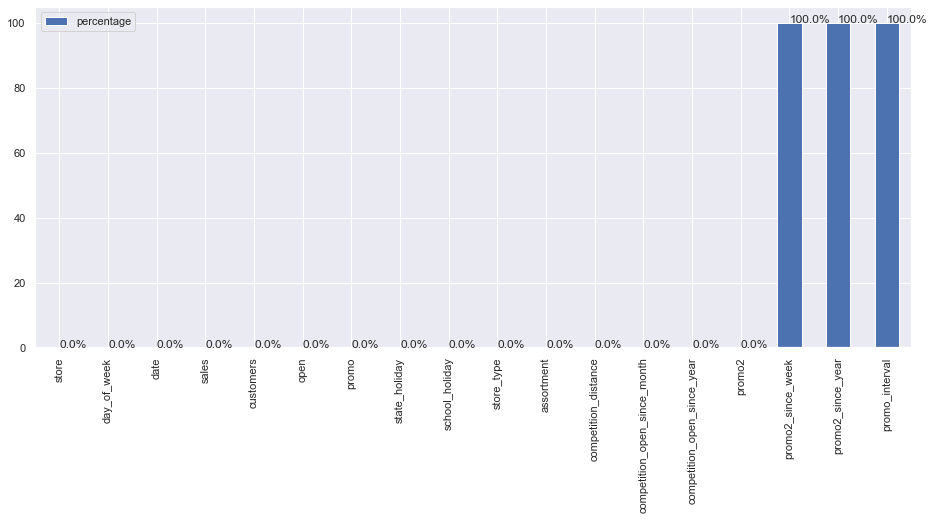

In [12]:
barchart = missing_df.plot.bar(y='percentage')
for index, percentage in enumerate( missing_percentage ):
    barchart.text( index, percentage, str(percentage)+'%')

In [13]:
#Let's drop the promo2_since_year,promo2_since_year,promo_interval
df_new_store1=df_new_store1.drop(['promo2_since_week', 'promo2_since_year','promo_interval'], axis = 1)

In [14]:
df_new_store1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 0 to 1016095
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   store                         942 non-null    int64         
 1   day_of_week                   942 non-null    int64         
 2   date                          942 non-null    datetime64[ns]
 3   sales                         942 non-null    int64         
 4   customers                     942 non-null    int64         
 5   open                          942 non-null    int64         
 6   promo                         942 non-null    int64         
 7   state_holiday                 942 non-null    object        
 8   school_holiday                942 non-null    int64         
 9   store_type                    942 non-null    object        
 10  assortment                    942 non-null    object        
 11  competition_distance        

In [15]:
df_new_store1 = df_new_store1.astype({'competition_open_since_month':'int64', 'competition_open_since_year':'int64',})
df_new_store1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 0 to 1016095
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   store                         942 non-null    int64         
 1   day_of_week                   942 non-null    int64         
 2   date                          942 non-null    datetime64[ns]
 3   sales                         942 non-null    int64         
 4   customers                     942 non-null    int64         
 5   open                          942 non-null    int64         
 6   promo                         942 non-null    int64         
 7   state_holiday                 942 non-null    object        
 8   school_holiday                942 non-null    int64         
 9   store_type                    942 non-null    object        
 10  assortment                    942 non-null    object        
 11  competition_distance        

In [16]:
df_new_store1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0
1115,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9,2008,0
2230,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9,2008,0
3345,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9,2008,0
4460,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9,2008,0


In [17]:
# Let's copy the dataset
df_store1 = df_new_store1.copy()

In [18]:
df_store1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0
1115,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9,2008,0
2230,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9,2008,0
3345,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9,2008,0
4460,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9,2008,0


**Descriptive Statistics**

In [19]:
df_store1.describe().T


,count,mean,std,min,25%,50%,75%,max
store,942.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
day_of_week,942.0,3.997877,1.998404,1.0,2.00,4.0,6.00,7.0
sales,942.0,3945.704883,2015.417840,0.0,3588.25,4373.5,5220.00,9528.0
customers,942.0,467.646497,228.930850,0.0,463.00,529.0,598.75,1130.0
open,942.0,0.829087,0.376633,0.0,1.00,1.0,1.00,1.0
promo,942.0,0.382166,0.486175,0.0,0.00,0.0,1.00,1.0
school_holiday,942.0,0.204883,0.403831,0.0,0.00,0.0,0.00,1.0
competition_distance,942.0,1270.000000,0.000000,1270.0,1270.00,1270.0,1270.00,1270.0
competition_open_since_month,942.0,9.000000,0.000000,9.0,9.00,9.0,9.00,9.0
competition_open_since_year,942.0,2008.000000,0.000000,2008.0,2008.00,2008.0,2008.00,2008.0


In [20]:
# separate numerical and categorical attributes
num_attributes = df_store1.select_dtypes( include = 'number')
cate_attributes = df_store1.select_dtypes( include = 'object')

**Numerical Attributes**

In [21]:
# Central Tendency - Mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtoisis
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( min )).T
d3 = pd.DataFrame(num_attributes.apply( max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()


m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1.0,0.0,1.000000,1.0,0.000000,0.000000,0.000000
1,day_of_week,1.0,7.0,6.0,3.997877,4.0,1.997343,0.002127,-1.247185
2,sales,0.0,9528.0,9528.0,3945.704883,4373.5,2014.347801,-0.880179,0.147313
3,customers,0.0,1130.0,1130.0,467.646497,529.0,228.809304,-1.148392,0.451971
4,open,0.0,1.0,1.0,0.829087,1.0,0.376433,-1.751240,1.069107
5,promo,0.0,1.0,1.0,0.382166,0.0,0.485917,0.485772,-1.767783
6,school_holiday,0.0,1.0,1.0,0.204883,0.0,0.403616,1.464696,0.145640
7,competition_distance,1270.0,1270.0,0.0,1270.000000,1270.0,0.000000,0.000000,0.000000
8,competition_open_since_month,9.0,9.0,0.0,9.000000,9.0,0.000000,0.000000,0.000000
9,competition_open_since_year,2008.0,2008.0,0.0,2008.000000,2008.0,0.000000,0.000000,0.000000


**Categorical Attributes**


In [22]:
# check unique values of categorical features
cate_attributes.apply( lambda x: x.unique().shape[0])

state_holiday    5
store_type       1
assortment       1
dtype: int64

In [23]:
#Let's check the unique values
print(df_store1['state_holiday'].unique())
print(df_store1['store_type'].unique())
print(df_store1['assortment'].unique())

['0' 'a' 'b' 'c' 0]
['c']
['a']


# **Exploratory data analysis(EDA)**

Let’s perform EDA to gain insights into the given data.

**Univariate Analysis**

*Response Variable (target)*

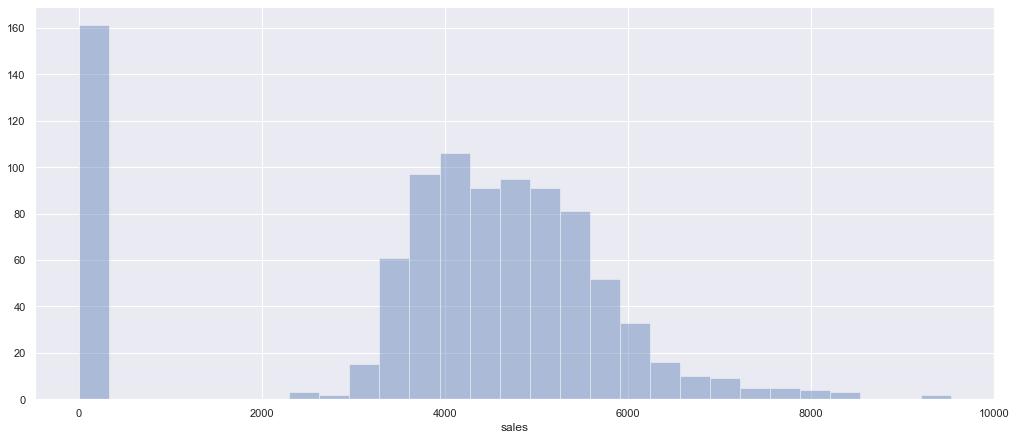

In [24]:
fig = plt.figure( figsize = (14, 6), constrained_layout=True)
sns.distplot(df_store1['sales'], kde = False);
plt.show()

**Numerical Variable**

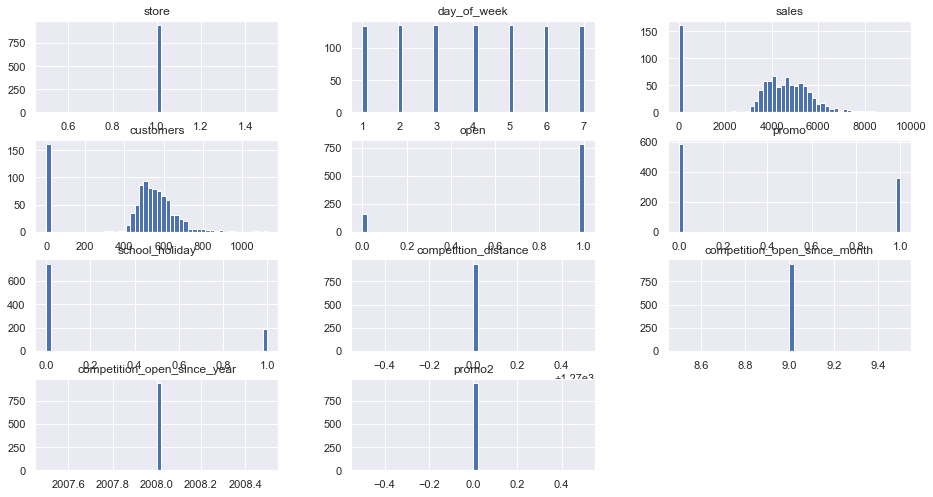

In [25]:
sns.set(rc={'figure.figsize':(15.7,8.27)})
num_attributes.hist(bins = 50);

In [26]:
df_store1['day_of_week'].value_counts()
#day of the week

5    135
4    135
3    135
2    135
7    134
6    134
1    134
Name: day_of_week, dtype: int64

In [27]:
df_store1['open'].value_counts()
# value count of store is open or not

1    781
0    161
Name: open, dtype: int64

In [28]:
df_store1['promo'].value_counts()
# value count of promo

0    582
1    360
Name: promo, dtype: int64

In [29]:
df_store1['state_holiday'].value_counts()
# value count of state_holiday

0    786
0    129
a     17
b      6
c      4
Name: state_holiday, dtype: int64

In [30]:
df_store1['school_holiday'].value_counts()
# value count of state_holiday

0    749
1    193
Name: school_holiday, dtype: int64

In [31]:
df_store1['store_type'].value_counts()
# value count of state_holiday

c    942
Name: store_type, dtype: int64

In [32]:
df_store1['assortment'].value_counts()
# value count of assortment

a    942
Name: assortment, dtype: int64

In [33]:
df_store1['competition_distance'].value_counts()
# value count of competition_distance

1270.0    942
Name: competition_distance, dtype: int64

In [34]:
df_store1['competition_open_since_month'].value_counts()
# value count of competition_open_since_month

9    942
Name: competition_open_since_month, dtype: int64

In [35]:
df_store1['competition_open_since_year'].value_counts()
# value count of competition_open_since_year

2008    942
Name: competition_open_since_year, dtype: int64

In [36]:
df_store1['promo2'].value_counts()
# value count of competition_open_since_year

0    942
Name: promo2, dtype: int64

df_store1.columns

**Categorical Variable**

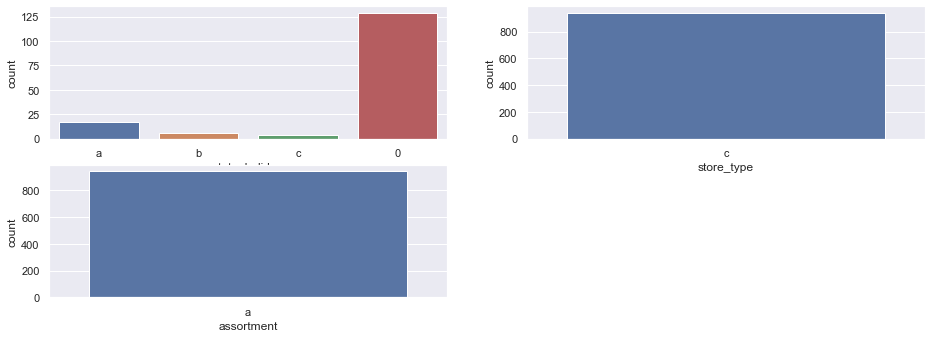

In [37]:
# state_holiday
plt.subplot(3, 2, 1)
a = df_store1[df_store1['state_holiday'] != '0']
sns.countplot(data = a, x = a['state_holiday'])

# store_type
plt.subplot(3, 2, 2)
sns.countplot(data = df_store1, x = df_store1['store_type'])

# assortment
plt.subplot(3, 2, 3)
sns.countplot(data = df_store1, x = df_store1['assortment'])
plt.show()

 - Sale colomns has zero values which has to be imputed 
 - Store is open on 80% of days
 - 80% are regular days
 - All the rows of column-store type belongs to 'c'
 - All the rows of column-assortment belongs to 'a'
 - All the rows of columns-competition_distance to 1270
 - All the competition is opened since month-9
 - All the competition is opened since 2008
 - All the rows of promo2 belogs to 0

**Bivariate Analysis**

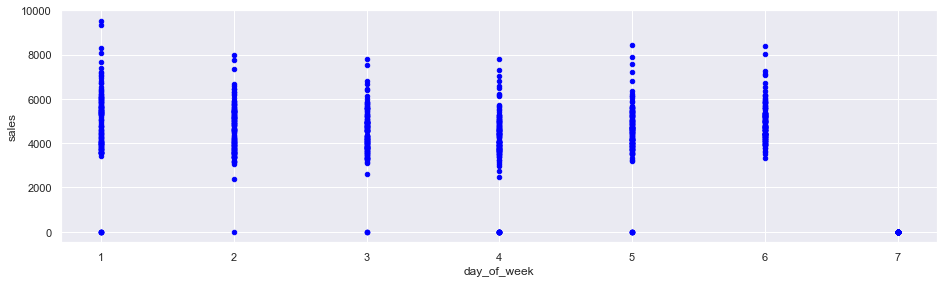

In [38]:
# lets draw a scatter plot between  Sales and day_of_week
sns.set(rc={'figure.figsize':(15.7,4.27)})
df_store1[['sales', 'day_of_week']].plot.scatter(x = 'day_of_week',y='sales',c='blue')
plt.show()

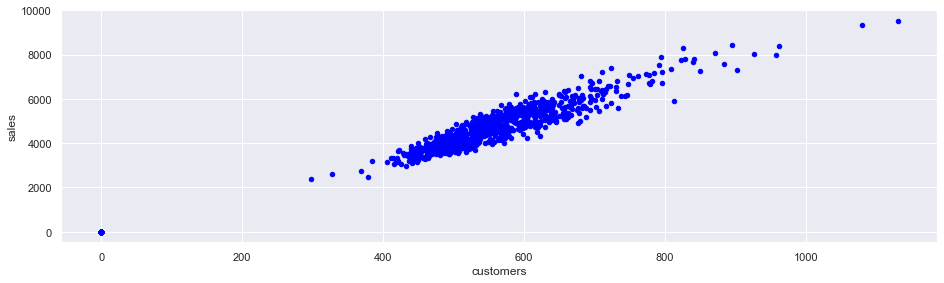

In [39]:
#Let's draw a scatter plot between Sales and Customers
df_store1[['sales', 'customers']].plot.scatter(x = 'customers',y='sales',c='blue')
plt.show()

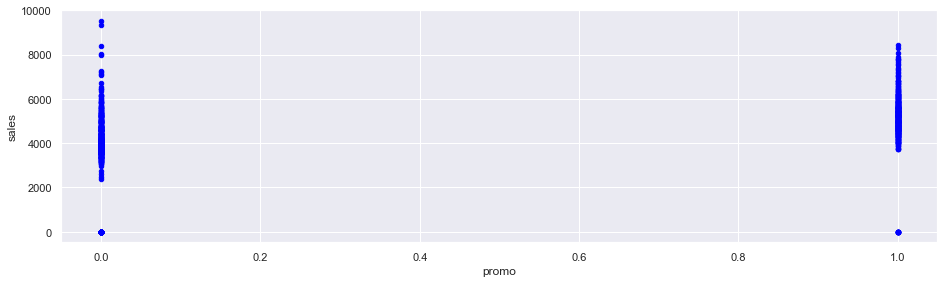

In [40]:
#Let's now draw a scatter plot between Sales and promo
df_store1[['sales', 'promo']].plot.scatter(x = 'promo',y='sales',c='blue')
plt.show()

In [41]:
df_store1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2'],
      dtype='object')

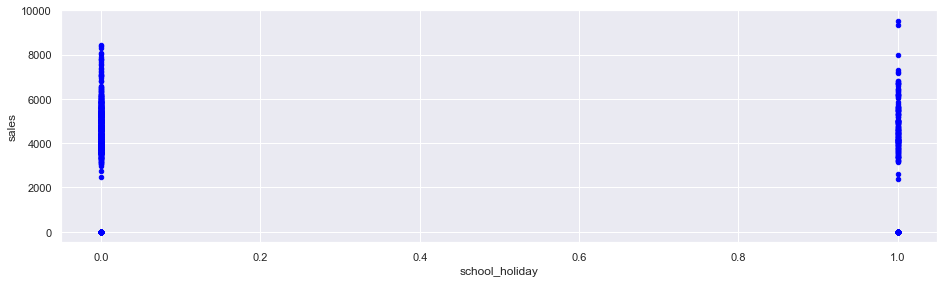

In [42]:
#lets now draw a scatter plot between  Sales and school_holiday
df_store1[['sales', 'school_holiday']].plot.scatter(x = 'school_holiday',y='sales',c='blue')
plt.show()

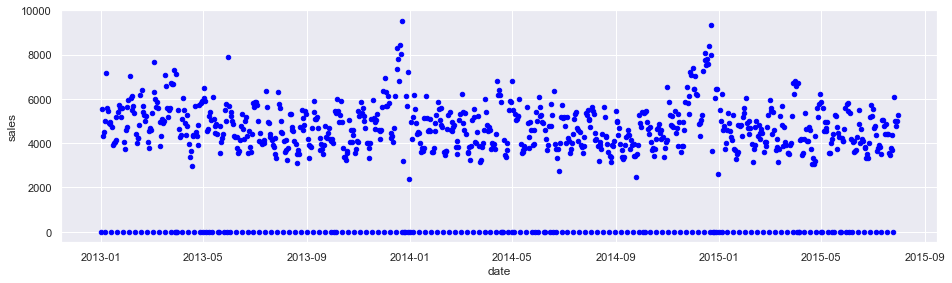

In [43]:
#lets now draw a scatter plot between Sales and date
df_store1[['sales', 'date']].plot.scatter(x = 'date',y='sales',c='blue')
plt.show()

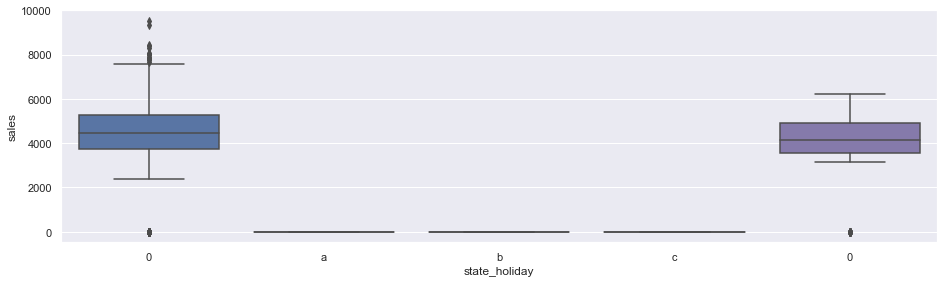

In [44]:
#Let's draw the boxplot between sales and state_holiday
sns.set(rc={'figure.figsize':(15.7,4.27)})
# create grouped boxplot 
sns.boxplot(x = df_store1['state_holiday'],
            y = df_store1['sales'])
plt.show()

**Multivariate Analysis**

**Numerical Attributes**

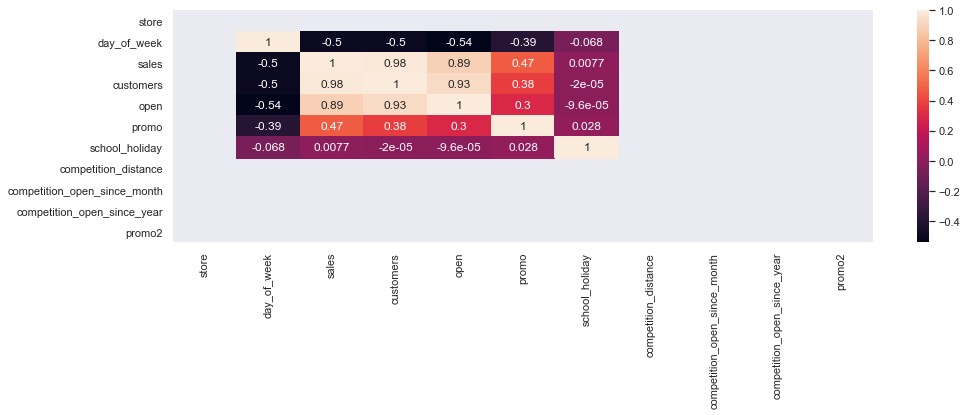

In [45]:
correlation = (num_attributes.corr( method = 'pearson' ))
sns.heatmap( correlation, annot = True );

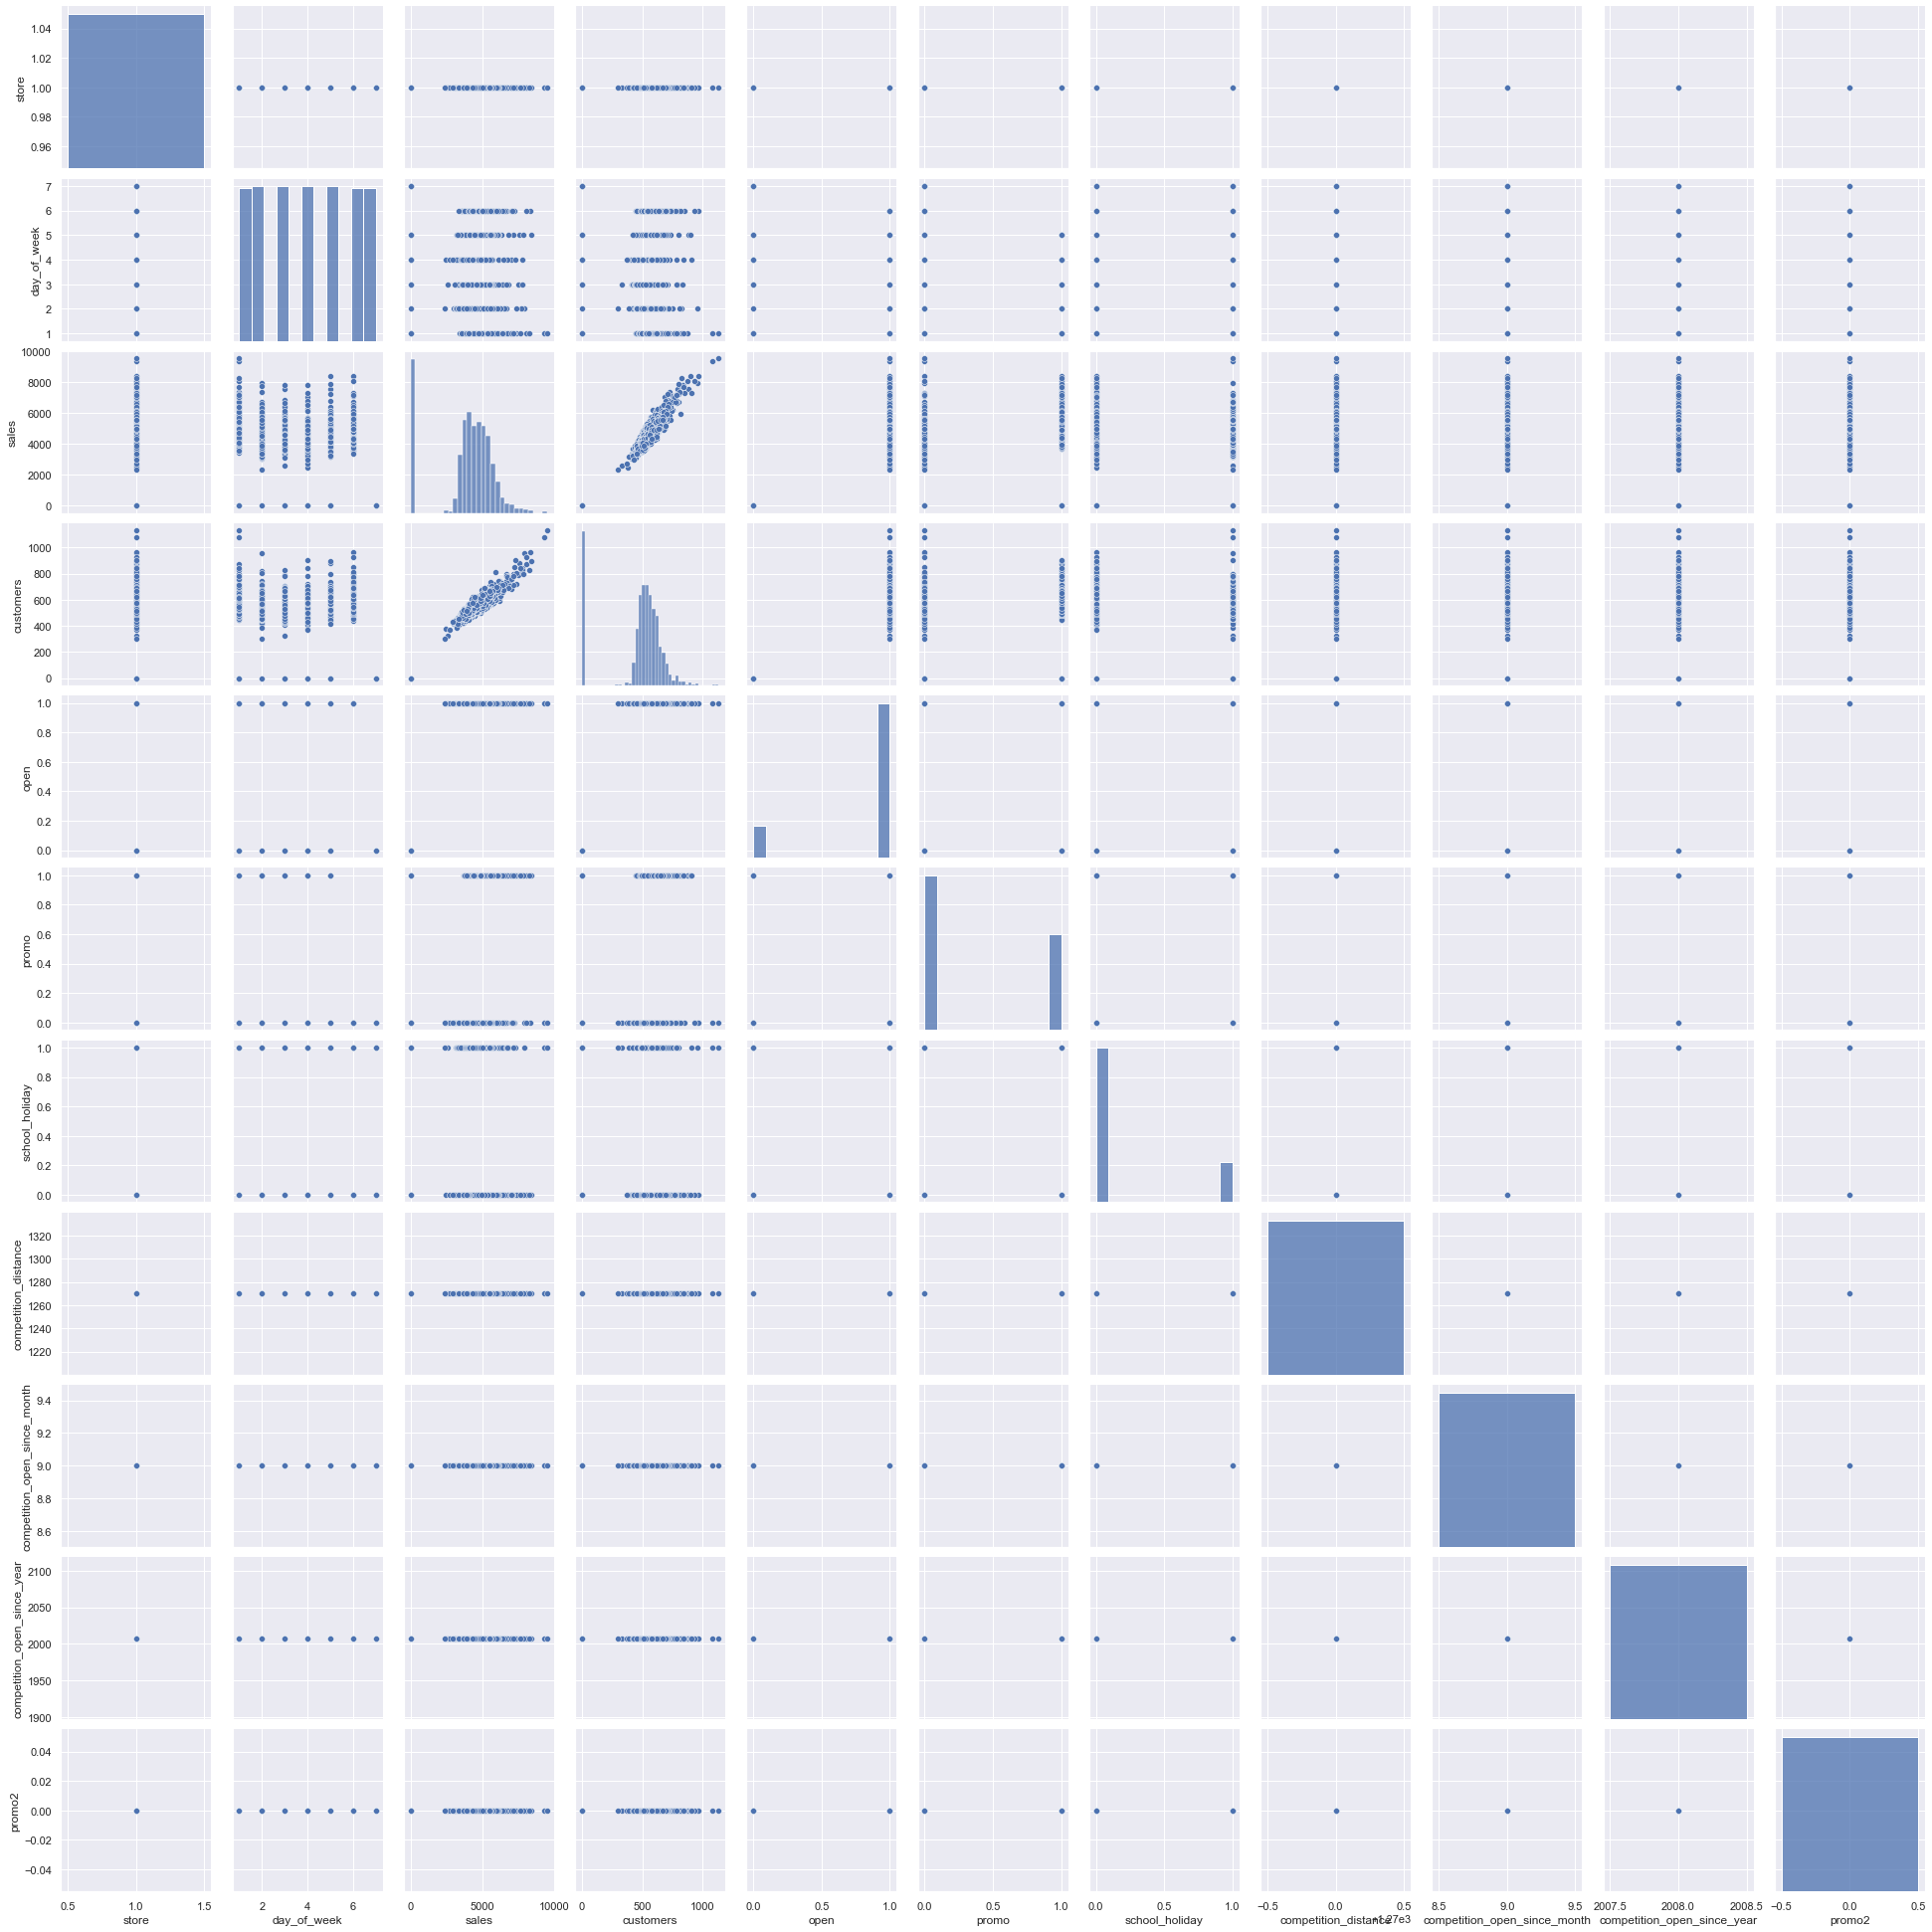

In [46]:
# pairplot with hue sales
sns.pairplot(df_store1)
# to show
plt.show()

**Some insights from EDA**

 - Sales & Customers are directly proportional to each other
 - store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year & promo2 are uncessary columns becuase it doesn't have any effect on sales(target variable)
 - Day1,Day5 and Day6 have higher sales than other days
 - promo is slighly correlated to sales
 - There is no sale on  a = public holiday, b = Easter holiday, c = Christmas
 - There is no effect of school holiday on sales

In [47]:
# We can drop store_type,assortment,competition_distance,competition_open_since_month,
#competition_open_since_year & promo2
df_store1_new=df_store1.drop(['store_type', 'assortment','competition_distance','competition_open_since_month','competition_open_since_year','promo2'], axis = 1)


In [48]:
df_store1_new.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday
0,1,5,2015-07-31,5263,555,1,1,0,1
1115,1,4,2015-07-30,5020,546,1,1,0,1
2230,1,3,2015-07-29,4782,523,1,1,0,1
3345,1,2,2015-07-28,5011,560,1,1,0,1
4460,1,1,2015-07-27,6102,612,1,1,0,1


In [49]:
# saving the dataframe
#df_store1_new.to_csv('cleaned_df_store1.csv')

# Model Building

**ARIMA model**

In [189]:
path = "cleaned_df_store1.csv"
df_store1_new = pd.read_csv(path)
df_store1_new.head()
#Let load the data

,Unnamed: 0,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday
0,0,1,5,2015-07-31,5263,555,1,1,0,1
1,1115,1,4,2015-07-30,5020,546,1,1,0,1
2,2230,1,3,2015-07-29,4782,523,1,1,0,1
3,3345,1,2,2015-07-28,5011,560,1,1,0,1
4,4460,1,1,2015-07-27,6102,612,1,1,0,1


In [190]:
df_store1_new=df_store1_new[::-1].reset_index()
df_store1_new

,index,Unnamed: 0,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday
0,941,1016095,1,2,2013-01-01,0,0,0,0,a,1
1,940,1014980,1,3,2013-01-02,5530,668,1,0,0,1
2,939,1013865,1,4,2013-01-03,4327,578,1,0,0,1
3,938,1012750,1,5,2013-01-04,4486,619,1,0,0,1
4,937,1011635,1,6,2013-01-05,4997,635,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
937,4,4460,1,1,2015-07-27,6102,612,1,1,0,1
938,3,3345,1,2,2015-07-28,5011,560,1,1,0,1
939,2,2230,1,3,2015-07-29,4782,523,1,1,0,1
940,1,1115,1,4,2015-07-30,5020,546,1,1,0,1


In [191]:
df_store1_new=df_store1_new.drop(['index'], axis = 1)
df_store1_new=df_store1_new.drop(['Unnamed: 0'], axis = 1)
df_store1_new.head()
#Let drop the Unnamed: 0 column

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday
0,1,2,2013-01-01,0,0,0,0,a,1
1,1,3,2013-01-02,5530,668,1,0,0,1
2,1,4,2013-01-03,4327,578,1,0,0,1
3,1,5,2013-01-04,4486,619,1,0,0,1
4,1,6,2013-01-05,4997,635,1,0,0,1


In [192]:
df_store1_new.info()
#No missing value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   store           942 non-null    int64 
 1   day_of_week     942 non-null    int64 
 2   date            942 non-null    object
 3   sales           942 non-null    int64 
 4   customers       942 non-null    int64 
 5   open            942 non-null    int64 
 6   promo           942 non-null    int64 
 7   state_holiday   942 non-null    object
 8   school_holiday  942 non-null    int64 
dtypes: int64(7), object(2)
memory usage: 66.4+ KB


In [193]:
df_store1_new['date'] = pd.to_datetime(df_store1_new['date'],infer_datetime_format=True)
# convert the string to datetime
df_store1_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   store           942 non-null    int64         
 1   day_of_week     942 non-null    int64         
 2   date            942 non-null    datetime64[ns]
 3   sales           942 non-null    int64         
 4   customers       942 non-null    int64         
 5   open            942 non-null    int64         
 6   promo           942 non-null    int64         
 7   state_holiday   942 non-null    object        
 8   school_holiday  942 non-null    int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 66.4+ KB


In [194]:
indexed_df_store1_new = df_store1_new.set_index(['date'])
indexed_df_store1_new.head(5)
#Let set the date as index column

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday
date,,,,,,,,
2013-01-01,1,2,0,0,0,0,a,1
2013-01-02,1,3,5530,668,1,0,0,1
2013-01-03,1,4,4327,578,1,0,0,1
2013-01-04,1,5,4486,619,1,0,0,1
2013-01-05,1,6,4997,635,1,0,0,1


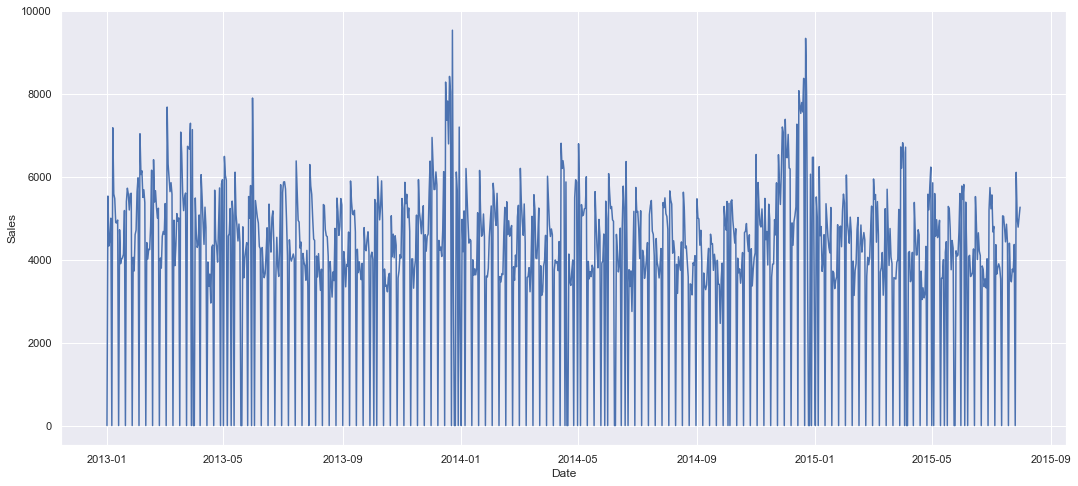

In [195]:
## plot graph
plt.xlabel('Date')
plt.ylabel('Sales')
plt.plot(indexed_df_store1_new['sales'])
plt.show()

In [196]:
#Let impute the zero values
(indexed_df_store1_new['sales']==0).sum()
# There are 161 zero value in sale column

161

In [197]:
indexed_df_store1_new['sales']=indexed_df_store1_new['sales'].replace(0, np.nan)

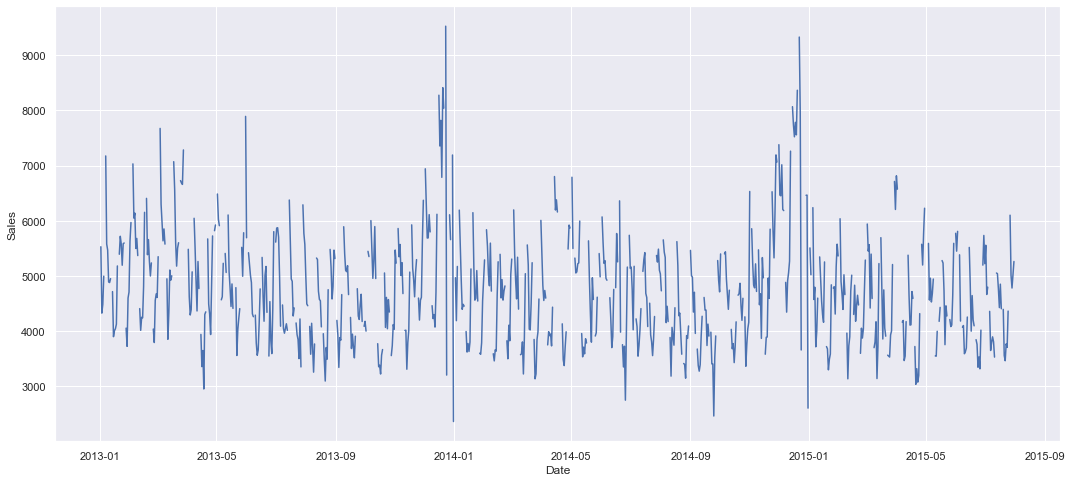

In [198]:
##plot graph
plt.xlabel('Date')
plt.ylabel('Sales')
plt.plot(indexed_df_store1_new['sales'])
plt.show()

In [199]:
#KNN imputer for filling NAN values
imputer = KNNImputer(n_neighbors=2)

In [200]:
indexed_df_store1_new['sales'] = imputer.fit_transform(np.array(indexed_df_store1_new['sales']).reshape(-1, 1))
indexed_df_store1_new['sales']

date
2013-01-01    4759.096031
2013-01-02    5530.000000
2013-01-03    4327.000000
2013-01-04    4486.000000
2013-01-05    4997.000000
                 ...     
2015-07-27    6102.000000
2015-07-28    5011.000000
2015-07-29    4782.000000
2015-07-30    5020.000000
2015-07-31    5263.000000
Name: sales, Length: 942, dtype: float64

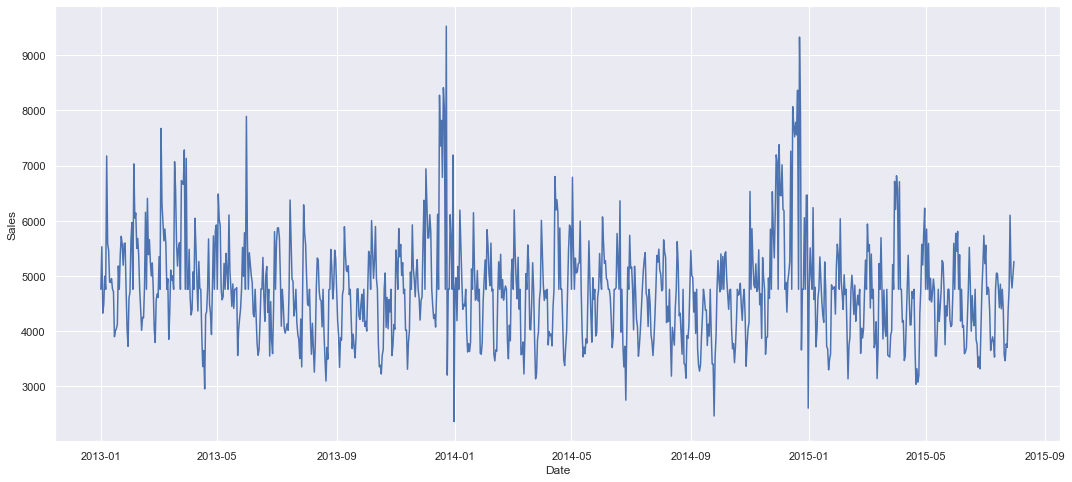

In [201]:
## plot graph
plt.xlabel('Date')
plt.ylabel('Sales')
plt.plot(indexed_df_store1_new['sales'])
plt.show()

In [202]:
(indexed_df_store1_new['sales']==0).sum()
# no missing value

0

**Outlier detection**

Box plot and interquartile range

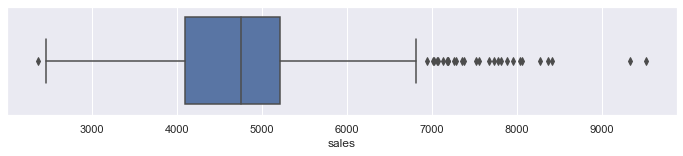

In [203]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=indexed_df_store1_new['sales'],whis=1.5)
#Let treat the outliers

**Histogram**


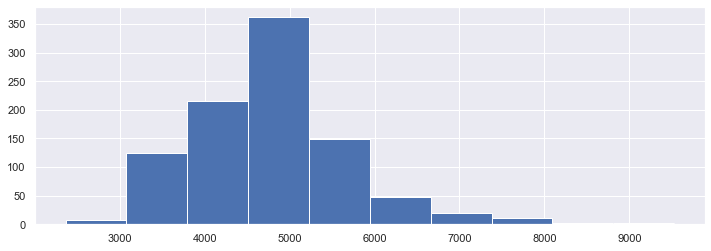

In [204]:
fig = indexed_df_store1_new['sales'].hist(figsize = (12,4))

In [205]:
percentile01 = indexed_df_store1_new['sales'].quantile(0.01)
percentile99 = indexed_df_store1_new['sales'].quantile(0.99)

In [206]:
upper_limit = percentile99
lower_limit = percentile01

In [207]:
upper_limit

7806.240000000001

In [208]:
lower_limit

3138.05

In [209]:
new_df = indexed_df_store1_new[indexed_df_store1_new['sales'] < upper_limit]
new_df.shape

(932, 8)

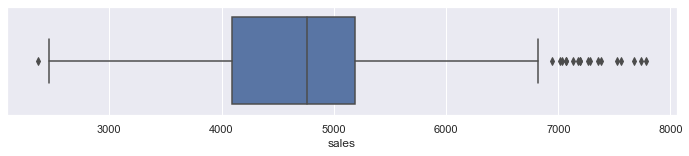

In [210]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=new_df['sales'],whis=1.5)

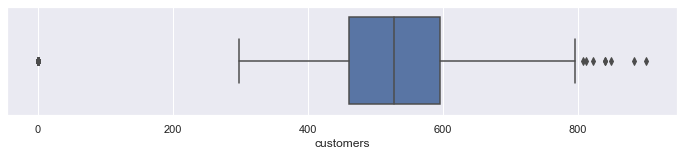

In [211]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=new_df['customers'],whis=1.5)

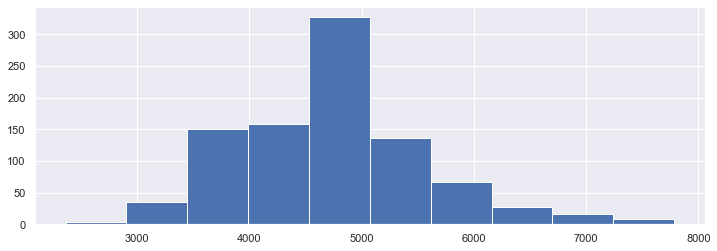

In [212]:
fig = new_df['sales'].hist(figsize = (12,4))

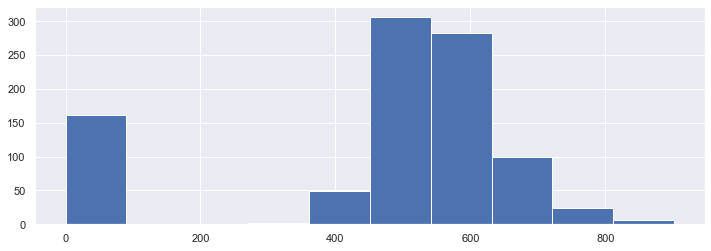

In [213]:
fig = new_df['customers'].hist(figsize = (12,4))

**ADF Stationary test**

In [214]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(indexed_df_store1_new['sales'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

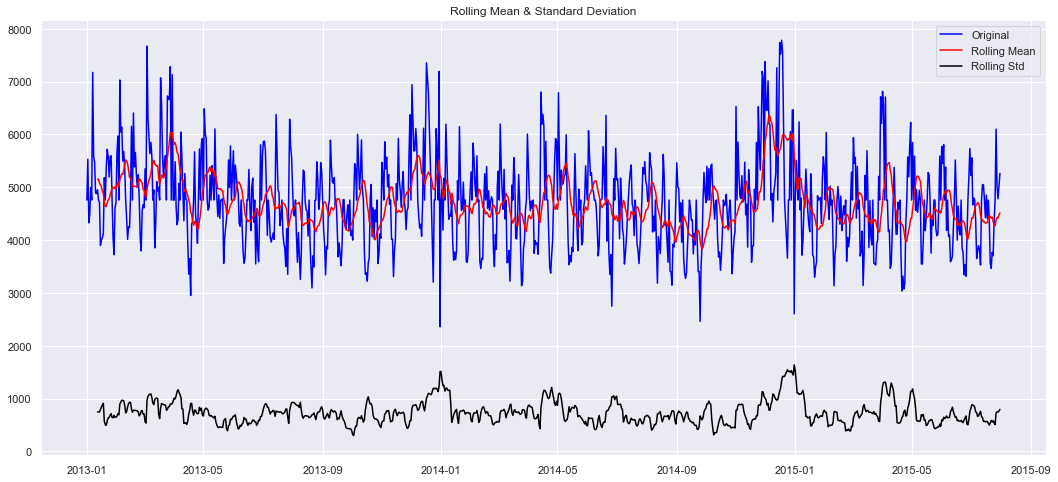

Results of Dickey Fuller Test:
Test Statistic                  -5.533321
p-value                          0.000002
#Lags Used                      16.000000
Number of Observations Used    925.000000
Critical Value (1%)             -3.437439
Critical Value (5%)             -2.864670
Critical Value (10%)            -2.568436
dtype: float64


In [215]:
test_stationarity(new_df['sales'])

- Null: Time Series is not stationary
- Alternate: Time Series is Stationary

**The p-value is less than 0.05 so The series is stationary**

In [216]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(new_df['sales'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.363547
Critical Values @ 0.05: 0.46
p-value: 0.092868


- Null: Time Series is not stationary
- Alternate: Time Series is Stationary

**The p-value is greater than 0.05 so The series is stationary**

**Decompostion of time series**

**Box Cox transformation to make variance constant**

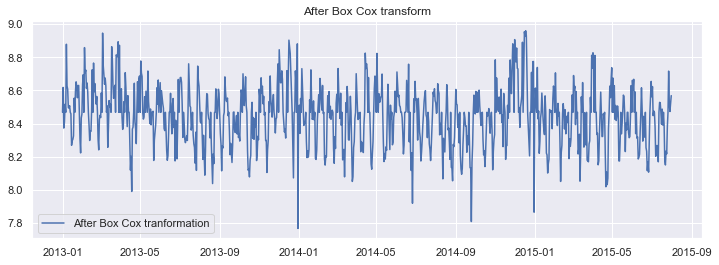

In [217]:
from scipy.stats import boxcox
boxcox_new_df = pd.Series(boxcox(new_df['sales'], lmbda=0), index = new_df.index)

plt.figure(figsize=(12,4))
plt.plot(boxcox_new_df, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

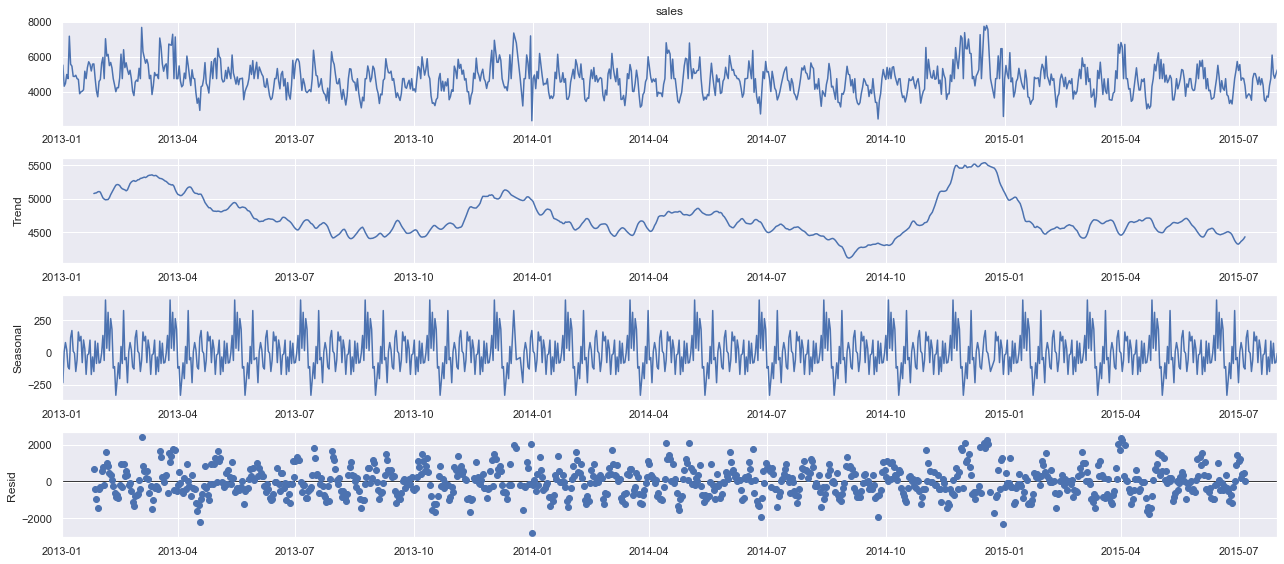

In [218]:
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 18,8
decomposition = sm.tsa.seasonal_decompose(new_df['sales'], model = "additive",period=50)
fig = decomposition.plot()

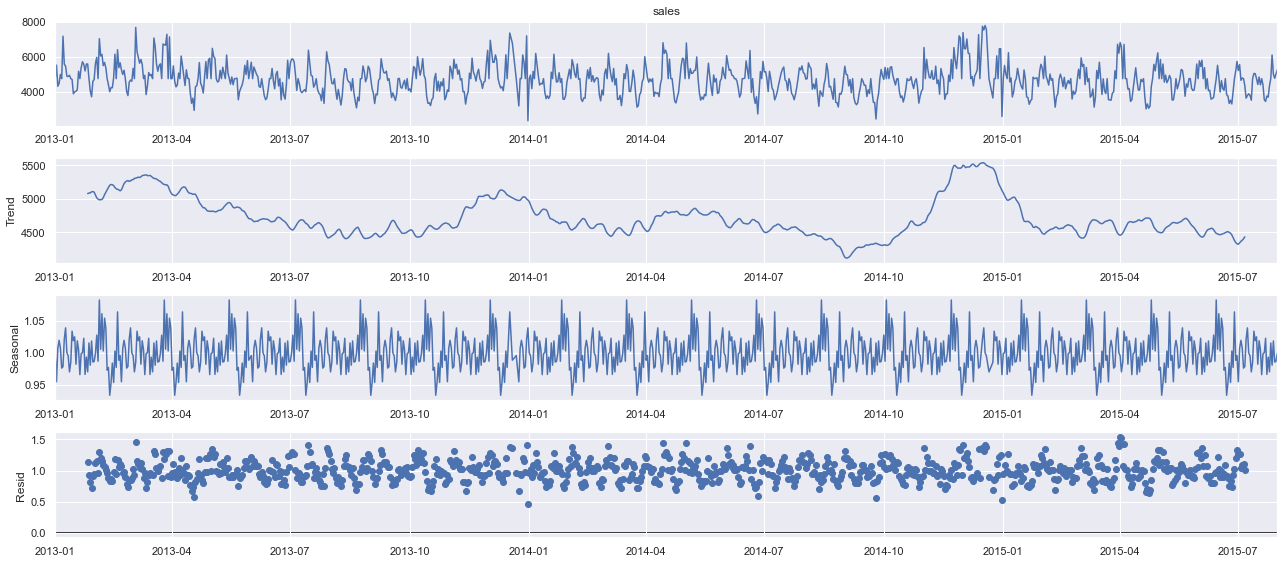

In [219]:
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 18,8
decomposition = sm.tsa.seasonal_decompose(new_df['sales'], model = "multiplicative",period=50)
fig = decomposition.plot()

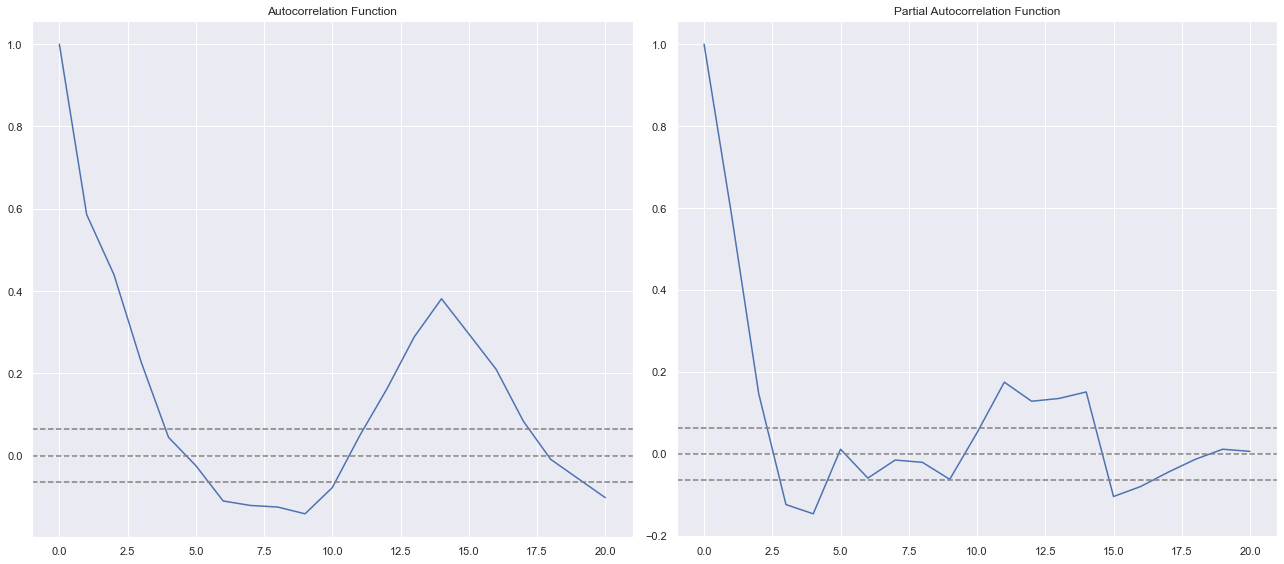

In [220]:
#ACF & PACF plots

lag_acf = acf(boxcox_new_df, nlags=20) # MA 
lag_pacf = pacf(boxcox_new_df, nlags=20, method='ols')  # AR 

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(new_df['sales'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(new_df['sales'])), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(new_df['sales'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(new_df['sales'])), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout() 

From the ACF graph, we see that curve touches y=0.0 line at x=5. Thus, from theory, Q = 5 From the PACF graph, we see that curve touches y=0.0 line at x=3. Thus, from theory, P = 3

**Build and evaluate time series forecast**

*Split time series data into training and test set*

In [221]:
train_len = 890
train = new_df['sales'][0:train_len] # first 890days as training set
test = new_df['sales'][train_len:] # last 42 days as out-of-time test set

In [222]:
print(train.shape)
print(test.shape)

(890,)
(42,)


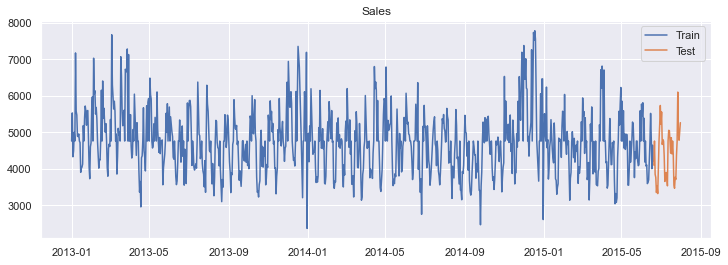

In [223]:
plt.figure(figsize=(12,4))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.legend(loc='best')
plt.title('Sales')
plt.show()

In [224]:
model = ARIMA(boxcox_new_df, order=(3, 0, 5))
model_fit = model.fit()
print(model_fit.params)

const      8.443995
ar.L1.y    1.407014
ar.L2.y   -0.348628
ar.L3.y   -0.329232
ma.L1.y   -0.950022
ma.L2.y    0.129485
ma.L3.y    0.150803
ma.L4.y    0.020695
ma.L5.y    0.193045
dtype: float64


In [225]:
new_df['ar_forecast_boxcox'] = model_fit.predict(boxcox_new_df.index.min(), boxcox_new_df.index.max())
new_df['arima_forecast_new'] = np.exp(new_df['ar_forecast_boxcox'])

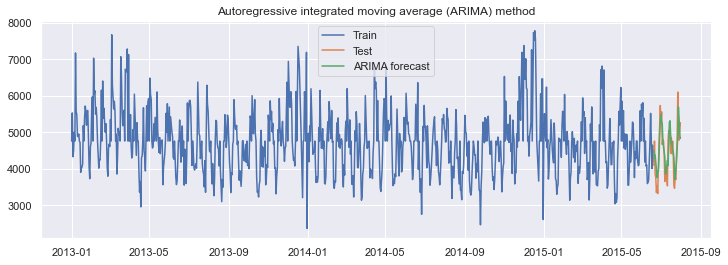

In [226]:
plt.figure(figsize=(12,4))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(new_df['arima_forecast_new'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('Autoregressive integrated moving average (ARIMA) method')
plt.show()

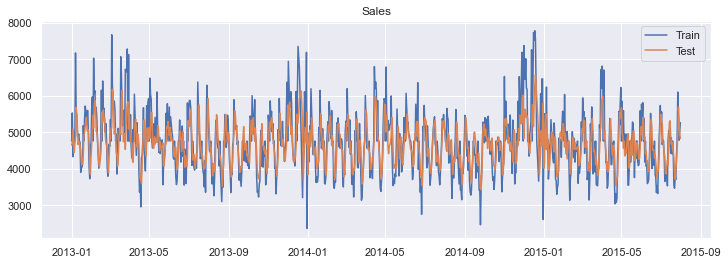

In [227]:
# plot the arima forecasting & Original series
plt.figure(figsize=(12,4))
plt.plot(new_df['sales'], label='Train')
plt.plot(new_df['arima_forecast_new'], label='Test')
plt.legend(loc='best')
plt.title('Sales')
plt.show()

In [228]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test, new_df['arima_forecast_new'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test-new_df['arima_forecast_new'][test.index.min():])/test)*100,2)
Results = pd.DataFrame({'Method':['ARIMA'], 'RMSE': [rmse],'MAPE': [mape] })
Results 

,Method,RMSE,MAPE
0,ARIMA,447.9,8.66


**VAR model**

In [229]:
#Load the dataset
new_df.head()

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,ar_forecast_boxcox,arima_forecast_new
date,,,,,,,,,,
2013-01-01,1,2,4759.096031,0,0,0,a,1,8.443995,4647.083039
2013-01-02,1,3,5530.000000,668,1,0,0,1,8.457874,4712.027288
2013-01-03,1,4,4327.000000,578,1,0,0,1,8.534457,5087.070091
2013-01-04,1,5,4486.000000,619,1,0,0,1,8.439152,4624.629560
2013-01-05,1,6,4997.000000,635,1,0,0,1,8.398970,4442.490269


**Split the dataset to training & testing**

In [230]:
#split the dataset
nobs = 42
train, test = new_df[0:-nobs], new_df[-nobs:]

# Check size
print(train.shape)
print(test.shape)  

(890, 10)
(42, 10)


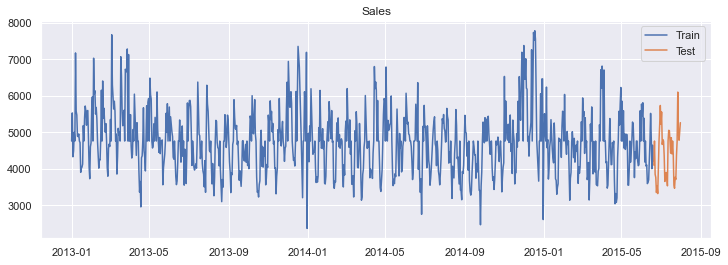

In [231]:
plt.figure(figsize=(12,4))
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.legend(loc='best')
plt.title('Sales')
plt.show()

**ADF Stationary test**

In [232]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(indexed_df_store1_new['sales'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

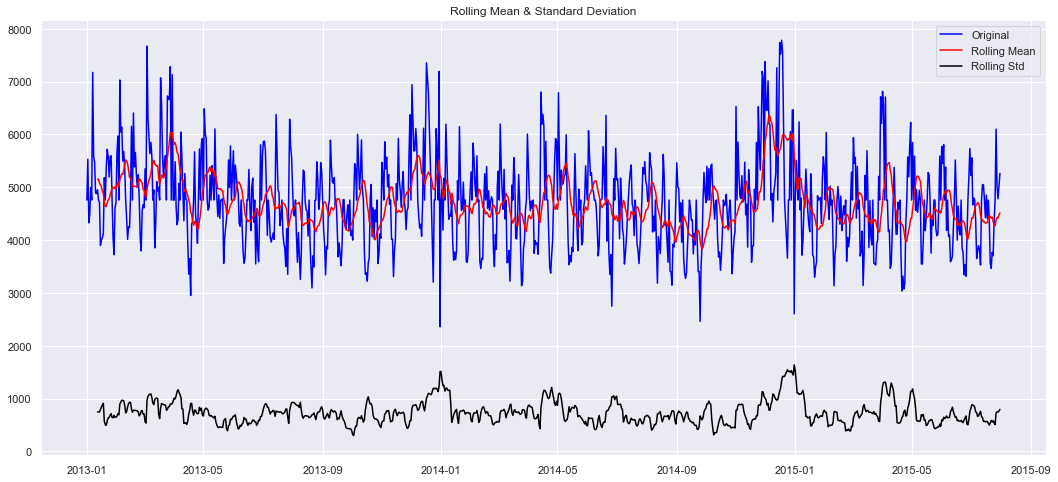

Results of Dickey Fuller Test:
Test Statistic                  -5.533321
p-value                          0.000002
#Lags Used                      16.000000
Number of Observations Used    925.000000
Critical Value (1%)             -3.437439
Critical Value (5%)             -2.864670
Critical Value (10%)            -2.568436
dtype: float64


In [233]:
test_stationarity(new_df['sales'])

- Null: Time Series is not stationary
- Alternate: Time Series is Stationary

**The p-value is less than 0.05 so The series is stationary**

In [234]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(new_df['sales'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.363547
Critical Values @ 0.05: 0.46
p-value: 0.092868


- Null: Time Series is not stationary
- Alternate: Time Series is Stationary

**The p-value is greater than 0.05 so The series is stationary**


In [235]:
#Load the dataset
new_df.head()

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,ar_forecast_boxcox,arima_forecast_new
date,,,,,,,,,,
2013-01-01,1,2,4759.096031,0,0,0,a,1,8.443995,4647.083039
2013-01-02,1,3,5530.000000,668,1,0,0,1,8.457874,4712.027288
2013-01-03,1,4,4327.000000,578,1,0,0,1,8.534457,5087.070091
2013-01-04,1,5,4486.000000,619,1,0,0,1,8.439152,4624.629560
2013-01-05,1,6,4997.000000,635,1,0,0,1,8.398970,4442.490269


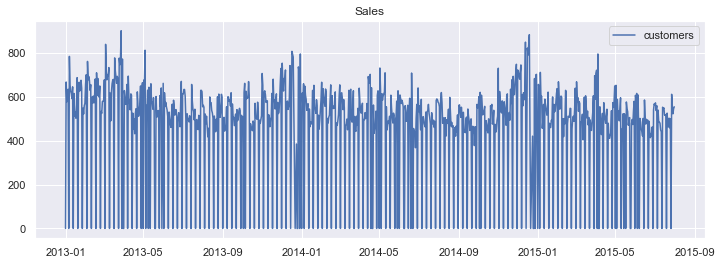

In [236]:
#plot the arima forecasting & Original series
plt.figure(figsize=(12,4))
plt.plot(new_df['customers'],label='customers')
plt.legend(loc='best')
plt.title('Sales')
plt.show()

In [237]:
(new_df['customers']==0).sum()

161

In [238]:
#impute the NAN values
new_df['customers']=new_df['customers'].replace(0, np.nan)

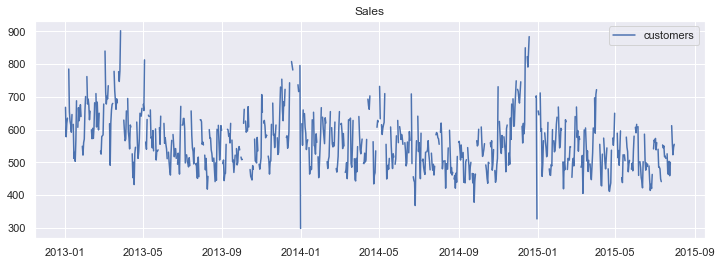

In [239]:
#plot the arima forecasting & Original series
plt.figure(figsize=(12,4))
plt.plot(new_df['customers'],label='customers')
plt.legend(loc='best')
plt.title('Sales')
plt.show()

In [240]:
#KNN imputer for filling NAN values
imputer = KNNImputer(n_neighbors=2)

In [241]:
new_df['customers'] = imputer.fit_transform(np.array(new_df['customers']).reshape(-1, 1))
new_df['customers']

date
2013-01-01    559.342412
2013-01-02    668.000000
2013-01-03    578.000000
2013-01-04    619.000000
2013-01-05    635.000000
                 ...    
2015-07-27    612.000000
2015-07-28    560.000000
2015-07-29    523.000000
2015-07-30    546.000000
2015-07-31    555.000000
Name: customers, Length: 932, dtype: float64

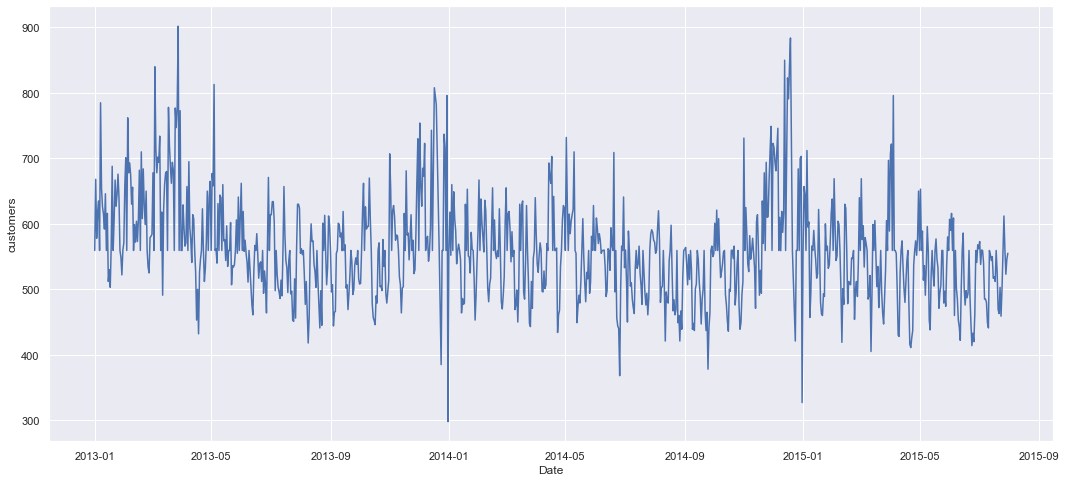

In [242]:
## plot graph
plt.xlabel('Date')
plt.ylabel('customers')
plt.plot(new_df['customers'])
plt.show()

In [243]:
new_df

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,ar_forecast_boxcox,arima_forecast_new
date,,,,,,,,,,
2013-01-01,1,2,4759.096031,559.342412,0,0,a,1,8.443995,4647.083039
2013-01-02,1,3,5530.000000,668.000000,1,0,0,1,8.457874,4712.027288
2013-01-03,1,4,4327.000000,578.000000,1,0,0,1,8.534457,5087.070091
2013-01-04,1,5,4486.000000,619.000000,1,0,0,1,8.439152,4624.629560
2013-01-05,1,6,4997.000000,635.000000,1,0,0,1,8.398970,4442.490269
...,...,...,...,...,...,...,...,...,...,...
2015-07-27,1,1,6102.000000,612.000000,1,1,0,1,8.498349,4906.663682
2015-07-28,1,2,5011.000000,560.000000,1,1,0,1,8.646584,5690.675574
2015-07-29,1,3,4782.000000,523.000000,1,1,0,1,8.590659,5381.159040


In [282]:
train_len = 890
train['sales'] = new_df['sales'][0:train_len] # first 890days as training set
test['sales'] = new_df['sales'][train_len:] # last 42 days as out-of-time test set

In [283]:
train

date
2013-01-01 00:00:00                                               4759.1
2013-01-02 00:00:00                                                 5530
2013-01-03 00:00:00                                                 4327
2013-01-04 00:00:00                                                 4486
2013-01-05 00:00:00                                                 4997
                                             ...                        
2015-06-16 00:00:00                                                 4852
2015-06-17 00:00:00                                                 4000
2015-06-18 00:00:00                                                 4645
2015-06-19 00:00:00                                                 4202
sales                  date
2013-01-01    4759.096031
2013-01-02    5...
Name: sales, Length: 891, dtype: object

**ADF Test**

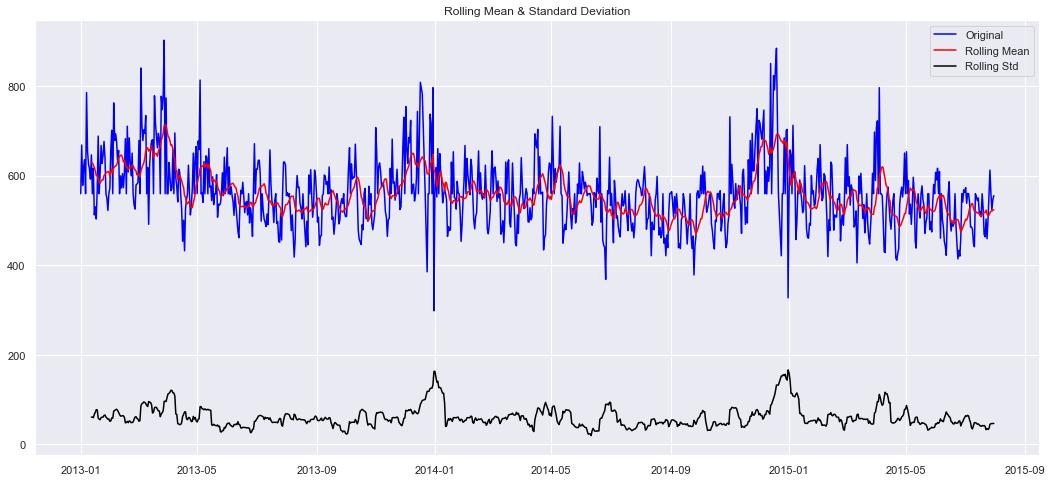

Results of Dickey Fuller Test:
Test Statistic                  -5.533321
p-value                          0.000002
#Lags Used                      16.000000
Number of Observations Used    925.000000
Critical Value (1%)             -3.437439
Critical Value (5%)             -2.864670
Critical Value (10%)            -2.568436
dtype: float64


In [244]:
test_stationarity(new_df['customers'])

- Null: Time Series is not stationary
- Alternate: Time Series is Stationary

**The p-value is less than 0.05 so The series is stationary**

In [245]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(new_df['sales'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.363547
Critical Values @ 0.05: 0.46
p-value: 0.092868


- Null: Time Series is not stationary
- Alternate: Time Series is Stationary

**The p-value is greater than 0.05 so The series is stationary**

**Sales and Customers are stationary time-series**

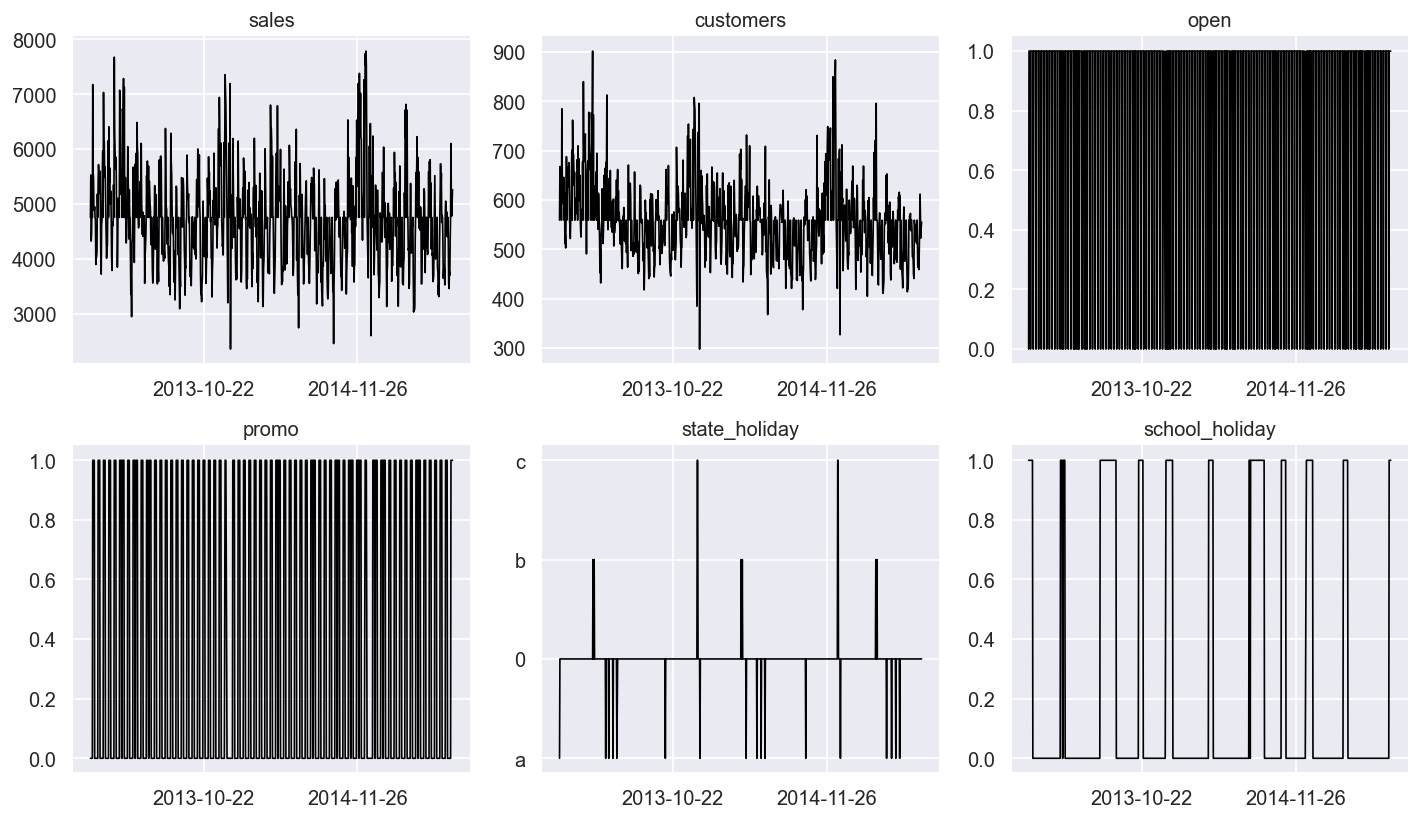

In [246]:
# Plot
ls=['sales','customers','open','promo','state_holiday','school_holiday']
df=new_df[ls]
fig, axes = plt.subplots(nrows=2, ncols=3, dpi=120, figsize=(12,7))
for i, ax in enumerate(axes.flatten()):
        ax.plot(df[df.columns[i]], color='black', linewidth=1)
        ax.xaxis.set_major_locator(plt.MaxNLocator(3))
        # Decorations
        ax.set_title(df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=12)

plt.tight_layout();

In [247]:
new_df.columns

Index(['store', 'day_of_week', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'ar_forecast_boxcox',
       'arima_forecast_new'],
      dtype='object')

In [248]:
new_df1=new_df[['sales', 'customers']]
new_df1

,sales,customers
date,,
2013-01-01,4759.096031,559.342412
2013-01-02,5530.000000,668.000000
2013-01-03,4327.000000,578.000000
2013-01-04,4486.000000,619.000000
2013-01-05,4997.000000,635.000000
...,...,...
2015-07-27,6102.000000,612.000000
2015-07-28,5011.000000,560.000000
2015-07-29,4782.000000,523.000000


In [249]:
#Let's create a model
model = VAR(new_df1)
for i in [1,2,3,4,5]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  19.682048205202648
BIC :  19.713216363810233
FPE :  353024581.9817617
HQIC:  19.69393530328319 

Lag Order = 2
AIC :  19.599156971606405
BIC :  19.651148203715515
FPE :  324941972.7001438
HQIC:  19.618986723774817 

Lag Order = 3
AIC :  19.583203084765877
BIC :  19.65605294735295
FPE :  319799135.5271851
HQIC:  19.61098987682219 

Lag Order = 4
AIC :  19.547803031871155
BIC :  19.641547181860542
FPE :  308676465.21278936
HQIC:  19.58356129108896 

Lag Order = 5
AIC :  19.4659985657696
BIC :  19.580672760421646
FPE :  284430869.8459274
HQIC:  19.50974276105932 



In [250]:
x = model.select_order(maxlags=5)
x.summary()

,AIC,BIC,FPE,HQIC
0,20.24,20.25,6.148e+08,20.24
1,19.68,19.71,3.512e+08,19.69
2,19.60,19.65,3.241e+08,19.62
3,19.58,19.65,3.192e+08,19.61
4,19.55,19.64,3.090e+08,19.58
5,19.47*,19.58*,2.844e+08*,19.51*


In [251]:
#Let's fit the model
model_fitted = model.fit()
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 10, Jan, 2022
Time:                     19:56:00
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    19.7132
Nobs:                     931.000    HQIC:                   19.6939
Log likelihood:          -11798.1    FPE:                3.53025e+08
AIC:                      19.6820    Det(Omega_mle):     3.50760e+08
--------------------------------------------------------------------
Results for equation sales
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const             2220.093161       181.911236           12.204           0.000
L1.sales             0.675521         0.069669            9.696           0.000
L1.customers        -1.230164         0.771950           -1.594 

In [252]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

1


In [253]:
# Input data for forecasting
forecast_input = new_df1.values[-lag_order:]
forecast_input

array([[5263.,  555.]])

In [254]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=new_df.index[-nobs:], columns=new_df1.columns + '_2d')
df_forecast

,sales_2d,customers_2d
date,,
2015-06-20,5092.621552,570.274620
2015-06-21,4958.736965,570.934838
2015-06-22,4867.482877,568.119644
2015-06-23,4809.301932,565.241091
2015-06-24,4773.540547,563.087284
2015-06-25,4752.032500,561.650417
2015-06-26,4739.270935,560.744648
2015-06-27,4731.764469,560.191577
2015-06-28,4727.374058,559.860291


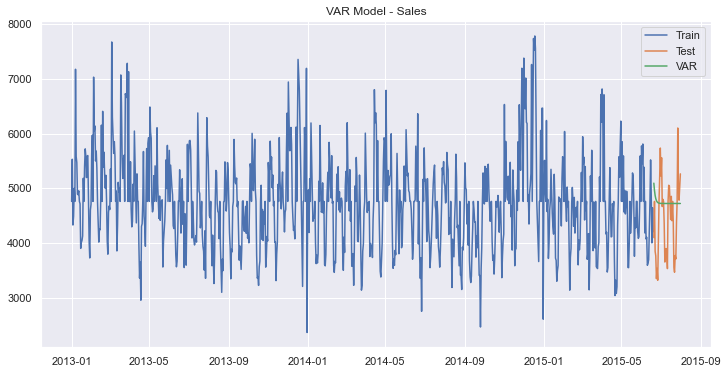

In [255]:
plt.figure(figsize=(12,6)) 
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(df_forecast['sales_2d'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Sales')
plt.show()

In [284]:
train_len = 890
train['customers'] = new_df['customers'][0:train_len] # first 890days as training set
test['customers'] = new_df['customers'][train_len:] # last 42 days as out-of-time test set

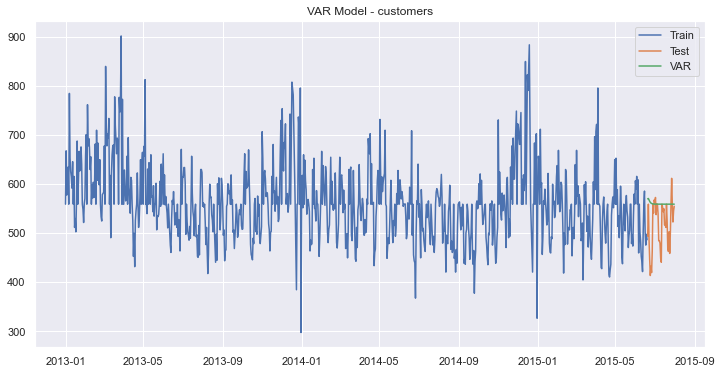

In [285]:
plt.figure(figsize=(12,6)) 
plt.plot(train['customers'], label='Train')
plt.plot(test['customers'], label='Test')
plt.plot(df_forecast['customers_2d'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - customers')
plt.show()

In [257]:
# Let's calculate the rmse and MAPE
rmse = np.sqrt(mean_squared_error(test['sales'], df_forecast['sales_2d'])).round(2)
mape = np.round(np.mean(np.abs(test['sales']-df_forecast['sales_2d'])/test['sales'])*100,2)
tempResults = pd.DataFrame({'Method':['VAR'], 'RMSE': [rmse],'MAPE': [mape] })

In [258]:
tempResults

,Method,RMSE,MAPE
0,VAR,762.28,15.07


In [259]:
results = pd.concat([Results , tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,ARIMA,447.90,8.66
0,VAR,762.28,15.07


**Johansen-Impulse**

In [260]:
joh_model1 = coint_johansen(new_df[['sales','customers']],-1,1)

In [261]:
joh_model1

In [262]:
joh_model1.lr2 #Max Eign Value Stats

array([159.21364297,   1.67043269])

In [263]:
joh_model1.lr1 #Trace Stats

array([160.88407566,   1.67043269])

In [264]:
new_df[['sales','customers']].shape #Shape of Data

(932, 2)

In [265]:
def joh_output(res):
    output = pd.DataFrame([res.lr2,res.lr1],
                          index=['max_eig_stat',"trace_stat"])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')

In [266]:
joh_output(joh_model1)

   max_eig_stat  trace_stat
0    159.213643  160.884076
1      1.670433    1.670433 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 



In [267]:
from statsmodels.tsa.vector_ar.vecm import select_coint_rank

In [268]:
rank=select_coint_rank(new_df[['sales','customers']],-1,1)
print(rank.rank)

1


**Rank is one**

In [269]:
from statsmodels.tsa.stattools import coint

In [270]:
coint(new_df['sales'],new_df['customers'])#null hypothesis-There is not coint

(-4.383312619898611,
 0.0018921042636345958,
 array([-3.90824227, -3.34270081, -3.04900867]))

0.0018921042636345958<.05

We can reject the null hypothesis

**Sales and customers are cointegration to each other**

**VARMAX MODEL**

In [271]:
# create dymmy variables
new_df=pd.get_dummies(new_df)
new_df.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,ar_forecast_boxcox,arima_forecast_new,state_holiday_0,state_holiday_a,state_holiday_b,state_holiday_c
date,,,,,,,,,,,,,
2013-01-01,1,2,4759.096031,559.342412,0,0,1,8.443995,4647.083039,0,1,0,0
2013-01-02,1,3,5530.000000,668.000000,1,0,1,8.457874,4712.027288,1,0,0,0
2013-01-03,1,4,4327.000000,578.000000,1,0,1,8.534457,5087.070091,1,0,0,0
2013-01-04,1,5,4486.000000,619.000000,1,0,1,8.439152,4624.629560,1,0,0,0
2013-01-05,1,6,4997.000000,635.000000,1,0,1,8.398970,4442.490269,1,0,0,0


In [272]:
exog = new_df[['open','promo','school_holiday','state_holiday_0','state_holiday_a','state_holiday_b','state_holiday_c']]
mod = sm.tsa.VARMAX(new_df[['sales', 'customers']], order=(1,1), trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                             Statespace Model Results                             
Dep. Variable:     ['sales', 'customers']   No. Observations:                  932
Model:                        VARMAX(1,1)   Log Likelihood              -11656.157
Date:                    Mon, 10 Jan 2022   AIC                          23362.314
Time:                            20:00:12   BIC                          23483.247
Sample:                                 0   HQIC                         23408.434
                                    - 932                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             0.02, 0.03   Jarque-Bera (JB):        296.27, 74.73
Prob(Q):                        0.88, 0.86   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.33, 0.89   Skew:                       0.81, 0.31
Prob(H) (two-sided):            0.01, 0.29   Kurtosis:                   5.24, 4.24


In [273]:
print(start_index)
print(end_index)

2015-06-20 00:00:00
2015-07-31 00:00:00


In [274]:
predictions = mod.fit().predict(start=start_index, end=end_index, exog=test['promo'])

In [275]:
predictions

,sales,customers
date,,
2015-06-20,4192.245451,515.929635
2015-06-21,4517.861538,534.002817
2015-06-22,4433.228113,544.985167
2015-06-23,4112.502146,517.415944
2015-06-24,4073.403931,503.598522
2015-06-25,3900.457373,487.789559
2015-06-26,3969.840347,494.805377
2015-06-27,3890.366288,489.018871
2015-06-28,4481.423171,523.340033


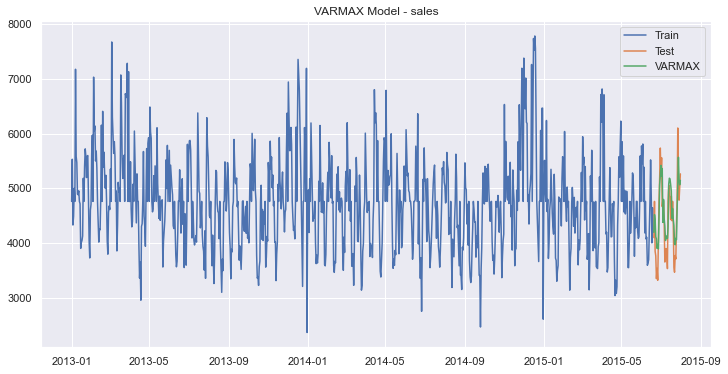

In [276]:
plt.figure(figsize=(12,6)) 
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(predictions['sales'], label='VARMAX')
plt.legend(loc='best')
plt.title('VARMAX Model - sales')
plt.show()

In [286]:
train_len = 890
train['customers'] = new_df['customers'][0:train_len] # first 890days as training set
test['customers'] = new_df['customers'][train_len:] # last 42 days as out-of-time test set

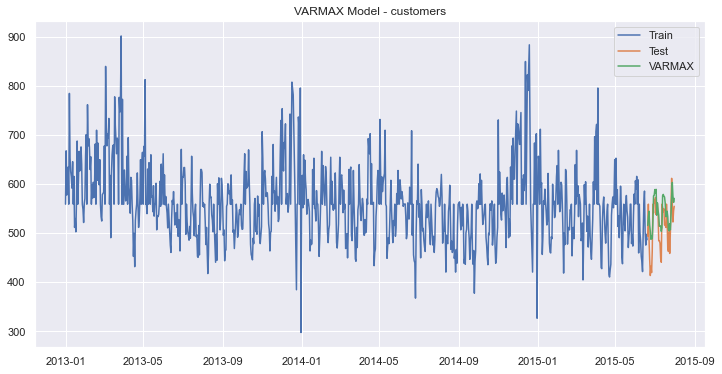

In [287]:
plt.figure(figsize=(12,6)) 
plt.plot(train['customers'], label='Train')
plt.plot(test['customers'], label='Test')
plt.plot(predictions['customers'], label='VARMAX')
plt.legend(loc='best')
plt.title('VARMAX Model - customers')
plt.show()

In [278]:
# Let's calculate the rmse and MAPE
rmse = np.sqrt(mean_squared_error(test['sales'], predictions['sales'])).round(2)
mape = np.round(np.mean(np.abs(test['sales']-predictions['sales'])/test['sales'])*100,2)
tempResults = pd.DataFrame({'Method':['VARMAX'], 'RMSE': [rmse],'MAPE': [mape] })

In [279]:
results = pd.concat([results  , tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,ARIMA,447.90,8.66
0,VAR,762.28,15.07
0,VARMAX,415.97,8.02


**VARMAX is the best model**

-  Is the sales data non-stationary? If so, how do you find it and correct it?

-  Is the data cointegrated? Which variables are cointegrated and how do you find them?

-  What is the impact of the number of customers on sales?

-  What is the impact of promo and promo2 variables on sales? How do you measure it?

-  **Forecast sales for the next 6 weeks? Report the accuracy of the model using MAPE**

-   Find outliers at the 99th percentile and remove them.

-   **Standardize the sales and number of customers variables before modelling**.

-   Determine if the data is stationary

-   If stationary then apply Vector Autoregression Model.

-   If non-stationary then specify the model in differences

-   Make sales, promo2 and any other variables you think of as dependent variables.

-   check for cointegration using the Johansen test. 

-   **Predict sales for the next 6 weeks**

# **Conclusion**

- The data is stationary
- Sales and Customers are cointegrated to each others
- Sales will get increase as the number of customer will get increase.
- promo has positive impact on sales
- promo2 doesn't have any impact on sales
